In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': '1tg7uu8GvstsNh8tMo5xq0kyCz9PHgB9s'})
downloaded.GetContentFile('train_identity.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1fFEYaig3cowq6K_TkJAt4DpMW3zVxekR'})
downloaded.GetContentFile('train_transaction.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1ko32LSWQj9dfrhkG2XwA2MsqAdFZf6eG'})
downloaded.GetContentFile('test_identity.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '19qclUn75nu2_bh0iz9ELlYlW0dajkt9p'})
downloaded.GetContentFile('test_transaction.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1KUkhQTM2oE52YF2x_Z_5PGXjAfM2UAG3'})
downloaded.GetContentFile('sample_submission.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1ifyhdZogZVk-Z4icaBQk4Qc3-8y-mhc7'})
downloaded.GetContentFile('model_backup')

In [ ]:
identity = pd.read_csv('train_identity.csv', encoding='latin-1')
transaction = pd.read_csv('train_transaction.csv', encoding='latin-1')
join = transaction.merge(identity, left_on= 'TransactionID', right_on='TransactionID',how='outer')

In [ ]:
identity = None
transaction = None

Elimino IDS unicos:

In [ ]:
join.drop(['TransactionID'], axis = 1, inplace=True)

In [ ]:
join.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


TransactionDT: timedelta de una fecha y hora de referencia dada (no una marca de tiempo real)
“El primer valor de TransactionDT es 86400, que corresponde a la cantidad de segundos en un día (60 * 60 * 24 = 86400), así que creo que la unidad es segundos. Con esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, que correspondería al día 183 ".

Entonces, para mi set de validación me voy a quedar con los que sean después de los 140 dias (aprox el 20%), osea **TransactionDT >= 140*86400 = 12.096.000**

In [ ]:
train = join[join['TransactionDT'] < 12096000]
validation = join[join['TransactionDT'] >= 12096000]

join = None

Tema: **NaN**

Si son de feature numericas: pasaran a ser el promedio de la columna.

Si son de feature no numerica: los cambio a 'Desconocido', así pasarán a ser una categoría del feature

In [ ]:
aux = train.select_dtypes(include = {'float64', 'int64'}).columns.values.tolist()
aux2 = {}
for elem in aux:
  aux2[elem] = train[elem].mean()

train.fillna(aux2, inplace=True)
validation.fillna(aux2, inplace=True)
# Hasta acá solo quedaron en NaN los de variables no numericas
train.fillna('Desconocido', inplace=True)
validation.fillna('Desconocido', inplace=True)

Algunos features tienen bastantes categorías, para achicarlos un poco me quedo con el top 10 y el resto serán categoría "Otros"

In [ ]:
device_info = train['DeviceInfo'].value_counts().to_frame().head(10).index
train.loc[~train['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'
validation.loc[~validation['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'


id_31 = train['id_31'].value_counts().to_frame().head(10).index
train.loc[~train['id_31'].isin(id_31), 'id_31'] = 'Otros'
validation.loc[~validation['id_31'].isin(id_31), 'id_31'] = 'Otros'

id_30 = train['id_30'].value_counts().to_frame().head(10).index
train.loc[~train['id_30'].isin(id_30), 'id_30'] = 'Otros'
validation.loc[~validation['id_30'].isin(id_30), 'id_30'] = 'Otros'

id_33 = train['id_33'].value_counts().to_frame().head(10).index
train.loc[~train['id_33'].isin(id_33), 'id_33'] = 'Otros'
validation.loc[~validation['id_33'].isin(id_33), 'id_33'] = 'Otros'

Voy a encodear con **Mean Encoding**

In [ ]:
a_encodear = train.select_dtypes(include = object).columns.values.tolist()
mean_encoded = {}
for elem in a_encodear:
  mean_encoded.update(train.groupby([elem])['isFraud'].mean().to_dict())
  train[elem] =  train[elem].map(mean_encoded)

a_encodear = None

In [ ]:
prom_features_train = {}
for column in train:
  prom_features_train[column] = train[column].mean()

In [ ]:
for column in validation:
  if (validation[column].dtype == object):
    validation[column] = validation[column].replace(mean_encoded)

In [ ]:
validation.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
469377,0,12096008,20.000,0.061840,2101,481.0,150.0,0.034909,224.0,0.067191,330.000000,87.000000,121.633845,237.634827,0.025991,0.114857,2.0,4.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,4.0,2.0,0.0,8.0,2.0,108.0,108.000000,28.636094,134.84658,42.362001,63.829504,44.639849,39.000000,0.000000,118.256468,...,0.000000,3154.00000,0.000000,0.000000,0.000000,0.000000,13.793258,-38.892032,0.000000,0.00000,100.000000,0.101090,47.457351,-300.000000,0.101090,0.101090,166.000000,14.184448,542.000000,533.000000,370.890905,16.017866,0.025991,12.757957,329.855724,148.303672,0.025991,0.101090,0.101090,0.130481,0.130481,24.000000,0.039957,0.038155,0.060319,0.093593,0.060319,0.060319,0.098894,0.130481
469378,0,12096009,15.950,0.020713,8320,476.0,150.0,0.034719,166.0,0.023978,325.000000,87.000000,5.000000,237.634827,0.119363,0.025991,139.0,125.0,0.0,0.0,237.0,107.0,0.0,0.0,93.0,0.0,97.0,0.0,683.0,116.0,54.0,54.000000,3.000000,53.00000,3.000000,63.829504,44.639849,149.826877,0.560621,53.000000,...,-9.927837,171070.98261,0.062681,-0.059743,1.728991,-6.628775,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.025991,47.457351,-345.677844,0.025991,0.025991,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.025991,12.757957,329.855724,148.303672,0.025991,0.025991,0.025991,0.025991,0.025991,26.599803,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991
469379,0,12096015,46.233,0.112989,7978,562.0,150.0,0.034909,219.0,0.067191,290.473133,86.771816,121.633845,282.000000,0.057932,0.057932,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,125.0,125.000000,0.000000,124.00000,0.000000,124.000000,0.000000,43.000000,0.000000,0.000000,...,-10.000000,111493.00000,0.000000,0.000000,0.000000,0.000000,13.793258,-38.892032,0.000000,0.00000,100.000000,0.049570,52.000000,-300.000000,0.101090,0.101090,225.000000,14.184448,266.000000,305.000000,370.890905,16.017866,0.025991,12.757957,329.855724,148.303672,0.025991,0.101090,0.101090,0.025991,0.018542,26.599803,0.025991,0.025991,0.093593,0.060319,0.060319,0.093593,0.062173,0.011521
469380,0,12096062,100.000,0.036368,5014,399.0,150.0,0.028719,146.0,0.067191,123.000000,87.000000,121.633845,237.634827,0.114857,0.114857,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,0.00000,42.362001,0.000000,44.639849,149.826877,0.560621,118.256468,...,-5.000000,167167.00000,0.062681,-0.059743,1.728991,-6.628775,13.793258,-38.892032,0.099801,-0.31037,100.000000,0.049570,64.000000,-300.000000,0.050593,0.049570,166.000000,14.184448,215.000000,600.000000,370.890905,16.017866,0.025991,12.757957,329.855724,148.303672,0.025991,0.050593,0.049570,0.130481,0.022514,24.000000,0.039957,0.038155,0.060319,0.093593,0.093593,0.093593,0.062173,0.018434
469381,0,12096068,117.000,0.020713,15484,418.0,150.0,0.034719,226.0,0.023978,264.000000,87.000000,97.000000,237.634827,0.028625,0.025991,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,5.0,2.0,63.0,63.000000,32.000000,63.00000,16.000000,63.829504,44.639849,149.826877,0.560621,32.000000,...,-9.927837,171070.98261,0.062681,-0.059743,1.728991,-6.628775,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.025991,47.457351,-345.677844,0.025991,0.025991,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.025991,12.757957,329.855724,148.303672,0.025991,0.025991,0.025991,0.025991,0.025991,26.599803,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991,0.025991


In [ ]:
x_train = train.drop('isFraud',axis=1)
y_train = train['isFraud']

In [ ]:
#logistic = LogisticRegression(random_state = 42, max_iter= 1500)

#hp = dict()
#hp['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
#hp['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
#hp['C'] = C = np.logspace(0, 4, num=10)

#model = RandomizedSearchCV(logistic, hp, random_state=42, n_jobs = 1, n_iter = 5, cv = 3, scoring="roc_auc")

In [ ]:
#model.fit(x_train, y_train)

In [ ]:
#with open('model_backup', 'wb') as model_backup_file:
 #   pickle.dump(model, model_backup_file)

In [ ]:
with open('model_backup', 'rb') as file:
    model = pickle.load(file)

**Hiperparametros:**

In [ ]:
model.best_params_

{'C': 59.94842503189409, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
model.best_estimator_.get_params()

{'C': 59.94842503189409,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Metricas:

In [ ]:
print(classification_report(y_train, model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    452890
           1       0.31      0.01      0.01     16487

    accuracy                           0.96    469377
   macro avg       0.64      0.50      0.50    469377
weighted avg       0.94      0.96      0.95    469377



In [ ]:
roc_auc_score(y_train, model.predict_proba(x_train)[:,1])

0.6971110448351885

**¿Cuál es el mejor score de validación obtenido?**

In [ ]:
x_val = validation.drop('isFraud',axis=1)
y_val = validation['isFraud']

In [ ]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    116987
           1       0.06      0.00      0.01      4176

    accuracy                           0.96    121163
   macro avg       0.51      0.50      0.49    121163
weighted avg       0.93      0.96      0.95    121163



In [ ]:
roc_auc_score(y_val, model.predict_proba(x_val)[:,1])

0.7039048215790555

**Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido?**

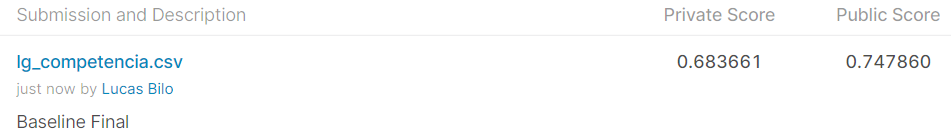

In [ ]:
columns_names = list(train.columns.values)
train = None
validation = None
x_train = None
y_train = None
x_val = None
y_val = None

In [ ]:
t_identity = pd.read_csv('test_identity.csv', encoding='latin-1')
t_transaction = pd.read_csv('test_transaction.csv', encoding='latin-1')
x_test = t_transaction.merge(t_identity, left_on= 'TransactionID', right_on='TransactionID',how='outer')
t_identity = None
t_transaction = None
x_test = x_test.drop(['TransactionID'], axis = 1) 
x_test.columns = x_test.columns.str.replace('id-','id_')

In [ ]:
x_test.fillna(aux2, inplace=True)
x_test.fillna('Desconocido', inplace=True)

In [ ]:
x_test.loc[~x_test['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'
x_test.loc[~x_test['id_31'].isin(id_31), 'id_31'] = 'Otros'
x_test.loc[~x_test['id_30'].isin(id_30), 'id_30'] = 'Otros'
x_test.loc[~x_test['id_33'].isin(id_33), 'id_33'] = 'Otros'

device_info = None
id_30 = None
id_31 = None
id_33 = None

In [ ]:
for column in x_test:
  if (x_test[column].dtype == object):
    x_test[column] = x_test[column].replace(mean_encoded)

In [ ]:
for column in x_test:
  x_test[column].fillna(prom_features_train[column], inplace=True)

In [ ]:
submission = pd.read_csv('sample_submission.csv', encoding='latin-1')

In [ ]:
pp = model.predict_proba(x_test)[:,1]
submission['isFraud'] = pp
submission.to_csv('lg_competencia.csv', index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.021320
1,3663550,0.022053
2,3663551,0.026874
3,3663552,0.041733
4,3663553,0.058985


**¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.**

In [ ]:
importance = model.best_estimator_.coef_

dic = {}
for i in range(len(importance[0])):
  dic[columns_names[i]] = abs(importance[0][i])

In [ ]:
df = pd.DataFrame([[key, dic[key]] for key in dic.keys()], columns=['Feature', 'Importancia'])
df = df.sort_values('Importancia',ascending=False)
df.set_index('Feature',inplace = True)

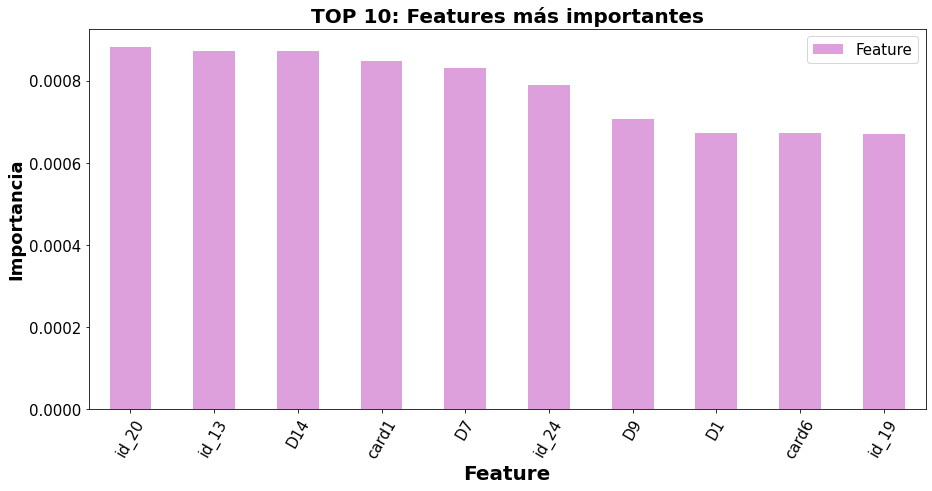

In [ ]:
df.iloc[1:11].plot.bar(logy=True, figsize=(15, 7), rot=60, color='plum', fontsize=15)
plt.title('TOP 10: Features más importantes', fontsize = 20, fontweight='bold')
plt.xlabel('Feature', fontsize=20, fontweight='bold')
plt.ylabel('Importancia', fontsize=18, fontweight='bold')
plt.yscale(value='linear')
plt.legend(('Feature',), loc='upper right', prop={'size':15})

plt.show()